In [1]:
import os

import warnings 
warnings.filterwarnings('ignore')

# importing packages
import numpy as np
import pandas as pd
import spacy
import pickle
from scipy import spatial
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
import unidecode
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer

from sentence_transformers import SentenceTransformer

# sklearn packages
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from xgboost import XGBClassifier

# utilies functions
import helper
import metrics as m

In [2]:
df = pd.read_csv("./output/queries_df.csv")
df.head()

,QUERY,REMEMBERING,UNDERSTANDING,APPLYING,ANALYZING,EVALUATING,CREATING
0,"""their own language"" means _ .",1.0,0.0,0.0,0.0,0.0,0.0
1,"""you may think the popular singer jay chow is ...",0.0,1.0,0.0,0.0,0.0,0.0
2,". at midnight, nasreddin saw _ in his garden.",1.0,0.0,0.0,0.0,0.0,0.0
3,. david beckham is _ years old.,1.0,0.0,0.0,0.0,0.0,0.0
4,. david beckham's family name is _ and zhou...,1.0,0.0,0.0,0.0,0.0,0.0


In [3]:
def unidecode_text(text):
    try:
        text = unidecode.unidecode(text)
    except:
        pass
    return text

In [4]:
df["QUERY_UC"] = df.QUERY.apply(unidecode_text)

In [5]:
categories = ["REMEMBERING", "UNDERSTANDING", "APPLYING", "ANALYZING", "EVALUATING", "CREATING"]

In [7]:
for category in categories:
    print(df[category].value_counts())

0.0    143926
1.0     45873
Name: REMEMBERING, dtype: int64
0.0    181279
1.0      8520
Name: UNDERSTANDING, dtype: int64
0.0    166346
1.0     23453
Name: APPLYING, dtype: int64
0.0    149809
1.0     39990
Name: ANALYZING, dtype: int64
0.0    173122
1.0     16677
Name: EVALUATING, dtype: int64
0.0    134513
1.0     55286
Name: CREATING, dtype: int64


In [8]:
df["QUERY_UC"].head()

0                     "their own language" means  _  .
1    "you may think the popular singer jay chow is ...
2     . at midnight, nasreddin saw   _  in his garden.
3                 . david beckham  is   _   years old.
4    . david beckham's family name is   _  and zhou...
Name: QUERY_UC, dtype: object

In [9]:
# list of word types (nouns and adjectives) to leave in the text
# defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN
    
# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        # doc_tok = [x for x in doc_tok if x not in stop_words1]
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        # doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        doc = [self.stemmer.stem(x) for x in doc]
        return doc

In [10]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,4), analyzer='word', #stop_words=stop_words1, 
                                               norm='l2', tokenizer=LemmaTokenizer())

In [11]:
clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.8)

In [ ]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        # returns the input as a string
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # returns the input as a dataframe
        return X[[self.key]]

In [82]:
def print_stats(preds, target, labels, sep='-', sep_len=40, fig_size=(10,8), categories=categories):
    print('Accuracy = %.3f' % metrics.accuracy_score(target, preds))
    print(sep*sep_len)
    print('Classification report:')
    print(metrics.classification_report(target, preds, target_names=categories))
    print(sep*sep_len)
    print('Confusion matrix')
    cm=metrics.confusion_matrix(target, preds)
    cm = cm / np.sum(cm, axis=1)[:,None]
    sns.set(rc={'figure.figsize':fig_size})
    sns.heatmap(cm, 
        xticklabels=labels,
        yticklabels=labels,
           annot=True, cmap = 'YlGnBu')
    plt.pause(0.05)

In [13]:
pipe = Pipeline([
    ('vect', vec_tdidf),
    ('clf', clf)
])

In [14]:
pipe.named_steps['clf'].get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'seed': 2}

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df["QUERY_UC"], df[categories], test_size=0.25, random_state=41)

In [16]:
labels = np.array(range(6))
y_train, y_test = np.dot(y_train.values, labels), np.dot(y_test.values, labels)

In [17]:
y_train[:5]

array([5., 0., 0., 4., 3.])

In [18]:
# definition of parameter grid to scan through
param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__colsample_bytree': [0.6, 0.8, 1]
    ,'clf__subsample': [0.6, 0.7, 0.8, 0.9]
}

In [19]:
# grid search cross validation instantiation
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, n_jobs=-1, verbose = 10, return_train_score=True)

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/kameni_a/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
grid_search.fit(X_train.values, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 36.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 61.1min
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed: 85.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 89.3min


In [25]:
grid_search.cv_results_['mean_train_score']

array([0.70087075, 0.70203514, 0.70466775, 0.70604114, 0.73888647,
       0.7417755 , 0.74429395, 0.74649277, 0.78147195, 0.78478247,
       0.78841615, 0.78995813, 0.70217915, 0.7042726 , 0.7060587 ,
       0.70751814, 0.74078322, 0.74396729, 0.74632769, 0.74851246,
       0.78374453, 0.78756612, 0.79068522, 0.79239229, 0.70348756,
       0.70512965, 0.70718446, 0.70838573, 0.74210216, 0.74502104,
       0.74764312, 0.7494942 , 0.78544984, 0.78992301, 0.79302103,
       0.79435929])

In [26]:
grid_search.cv_results_['mean_test_score']

array([0.65059822, 0.6505912 , 0.65072466, 0.6508792 , 0.6675495 ,
       0.66941112, 0.66934791, 0.66901772, 0.68077754, 0.68240033,
       0.68188752, 0.68129037, 0.6492424 , 0.65028911, 0.65001513,
       0.65005026, 0.66809745, 0.6691512 , 0.66871565, 0.6687016 ,
       0.6806511 , 0.68155029, 0.68072837, 0.6812131 , 0.64938991,
       0.64965686, 0.65014861, 0.64971306, 0.66722635, 0.66784455,
       0.66882103, 0.66823795, 0.68103747, 0.68110069, 0.68094615,
       0.6803982 ])

In [27]:
grid_search.best_params_

{'clf__colsample_bytree': 0.6, 'clf__n_estimators': 200, 'clf__subsample': 0.7}

In [28]:
clf_test = grid_search.best_estimator_

In [29]:
preds = clf_test.predict(X_test)

Accuracy = 0.688
----------------------------------------
Classification report:
               precision    recall  f1-score   support

  REMEMBERING       0.79      0.67      0.72     13639
UNDERSTANDING       0.41      0.54      0.47      1634
     APPLYING       0.42      0.67      0.52      3722
    ANALYZING       0.77      0.68      0.72     11108
   EVALUATING       0.48      0.67      0.56      2957
     CREATING       0.77      0.74      0.75     14390

     accuracy                           0.69     47450
    macro avg       0.61      0.66      0.62     47450
 weighted avg       0.72      0.69      0.70     47450

----------------------------------------
Confusion matrix


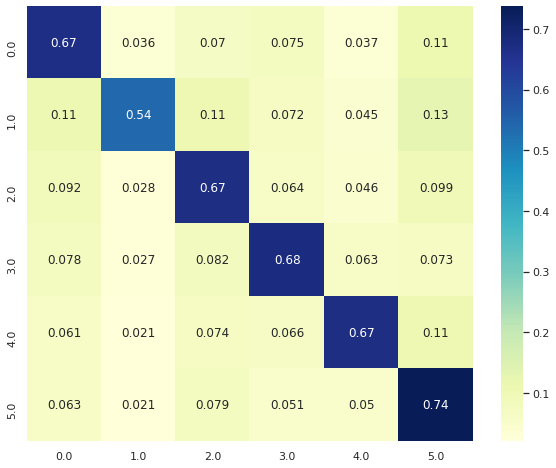

In [30]:
print_stats(y_test, preds, clf_test.classes_)

pip install imblearn

In [32]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.over_sampling import SMOTE  
from imblearn.pipeline import Pipeline as imbPipeline

In [34]:
clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7, 
                    n_estimators=300)
sm = SMOTE(random_state=42, sampling_strategy='auto')
pipe = imbPipeline([('vect', vec_tdidf),
                    ('smote', sm),
                    ('clf',clf)
                 ])

In [35]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(ngram_range=(1, 4),
                                 tokenizer=<__main__.LemmaTokenizer object at 0x7fb09daf8b38>)),
                ('smote', SMOTE(random_state=42)),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=300,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', random_state=42,
                               reg_alpha=0, reg_lambda=1, s

Accuracy = 0.688
----------------------------------------
Classification report:
               precision    recall  f1-score   support

  REMEMBERING       0.74      0.71      0.72     12046
UNDERSTANDING       0.52      0.46      0.49      2415
     APPLYING       0.41      0.68      0.51      3539
    ANALYZING       0.78      0.67      0.72     11556
   EVALUATING       0.54      0.62      0.58      3640
     CREATING       0.77      0.74      0.76     14254

     accuracy                           0.69     47450
    macro avg       0.63      0.65      0.63     47450
 weighted avg       0.71      0.69      0.69     47450

----------------------------------------
Confusion matrix


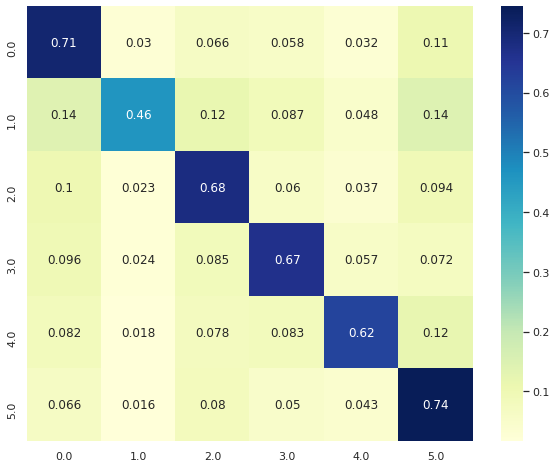

In [36]:
preds = pipe.predict(X_test)
print_stats(y_test, preds, pipe.classes_)

In [37]:
preds_proba = pipe.predict_proba(X_test)

In [38]:
preds_proba.shape

(47450, 6)

In [40]:
performances = m.get_performance_metrics(df[categories].loc[X_test.index].values, preds_proba, categories)
performances

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,7820,33419,2424,3787,0.869,0.245,0.674,0.932,0.763,0.898,0.921,0.716,0.5
UNDERSTANDING,933,44501,811,1205,0.958,0.045,0.436,0.982,0.535,0.974,0.922,0.481,0.5
APPLYING,2010,40873,680,3887,0.904,0.124,0.341,0.984,0.747,0.913,0.863,0.468,0.5
ANALYZING,7263,34756,2858,2573,0.886,0.207,0.738,0.924,0.718,0.931,0.931,0.728,0.5
EVALUATING,1987,42357,946,2160,0.935,0.087,0.479,0.978,0.677,0.951,0.927,0.561,0.5
CREATING,9850,30855,2770,3975,0.858,0.291,0.712,0.918,0.781,0.886,0.922,0.745,0.5


In [41]:
preds_proba = clf_test.predict_proba(X_test)
performances = m.get_performance_metrics(df[categories].loc[X_test.index].values, preds_proba, categories)
performances

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,8328,32720,3123,3279,0.865,0.245,0.717,0.913,0.727,0.909,0.92,0.722,0.5
UNDERSTANDING,716,44872,440,1422,0.961,0.045,0.335,0.99,0.619,0.969,0.926,0.435,0.5
APPLYING,2071,40868,685,3826,0.905,0.124,0.351,0.984,0.751,0.914,0.875,0.479,0.5
ANALYZING,6954,35046,2568,2882,0.885,0.207,0.707,0.932,0.73,0.924,0.931,0.718,0.5
EVALUATING,1652,42741,562,2495,0.936,0.087,0.398,0.987,0.746,0.945,0.927,0.519,0.5
CREATING,9763,30894,2731,4062,0.857,0.291,0.706,0.919,0.781,0.884,0.921,0.742,0.5


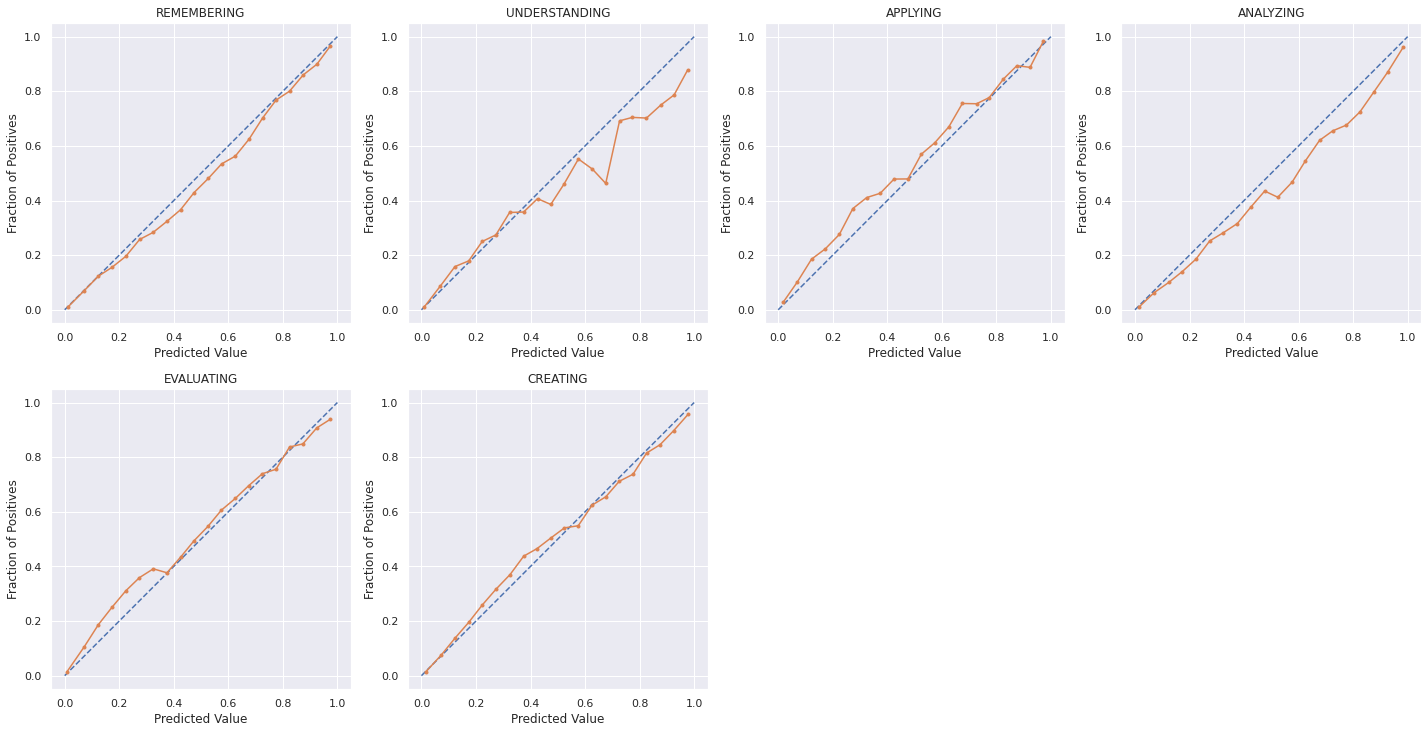

In [42]:
m.plot_calibration_curve(df[categories].loc[X_test.index].values, preds_proba, categories)

In [43]:
statistics = m.bootstrap_auc(df[categories].loc[X_test.index].values, preds_proba, categories)

In [44]:
m.print_confidence_intervals(categories, statistics)

,Mean AUC (CI 5%-95%)
REMEMBERING,0.92 (0.91-0.93)
UNDERSTANDING,0.93 (0.89-0.95)
APPLYING,0.87 (0.84-0.90)
ANALYZING,0.93 (0.91-0.94)
EVALUATING,0.93 (0.91-0.95)
CREATING,0.92 (0.90-0.93)


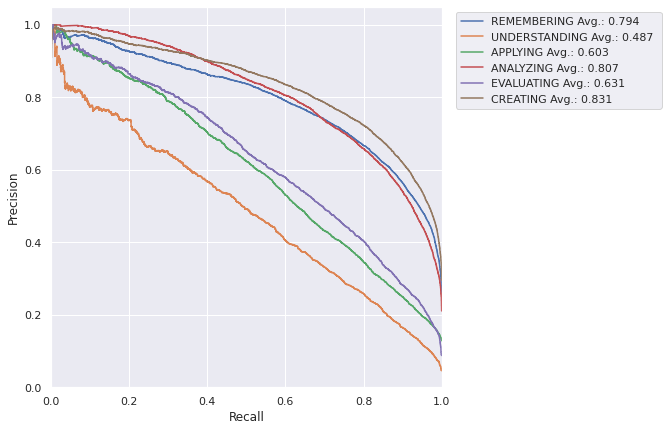

In [46]:
m.get_curve(df[categories].loc[X_test.index].values, preds_proba, categories, curve= 'prc')

In [47]:
pipe.named_steps['vect'].get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 4),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <__main__.LemmaTokenizer at 0x7fb09daf8b38>,
 'use_idf': True,
 'vocabulary': None}

In [48]:
# definition of parameter grid to scan through
param_grid = {
    'vect__ngram_range': [(1,1), (1, 2), (1, 3), (1,4), (1,5)],
    'vect__max_df': [0.2, 0.15, 0.5],
    'vect__min_df': [1, 3, 5],
}

In [49]:
# grid search cross validation instantiation
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, n_jobs=-1, verbose = 10, return_train_score=True)

In [ ]:
grid_search.fit(X_train.values, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.


In [53]:
grid_search.best_score_

0.6873318599197794

In [54]:
grid_search.cv_results_['mean_test_score']

array([0.61716627, 0.65963933, 0.65474293, 0.64820971, 0.64209795,
       0.61774934, 0.65875419, 0.6595129 , 0.65895792, 0.65784096,
       0.61829027, 0.6577426 , 0.6590071 , 0.65864181, 0.65907734,
       0.59378006, 0.65392099, 0.65109696, 0.64640427, 0.64199961,
       0.59295112, 0.65218584, 0.65267057, 0.65160275, 0.65210855,
       0.59277549, 0.65108291, 0.65081596, 0.65111101, 0.65118829,
       0.66899663, 0.6865872 , 0.67947793, 0.6701909 , 0.6628568 ,
       0.66927061, 0.68733186, 0.68639755, 0.68695955, 0.6855124 ,
       0.66871564, 0.6868682 , 0.68573016, 0.68662233, 0.68602521])

In [55]:
grid_search.best_params_

{'vect__max_df': 0.5, 'vect__min_df': 3, 'vect__ngram_range': (1, 2)}

In [56]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_vect__max_df', 'param_vect__min_df', 'param_vect__ngram_range', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [58]:
clf_test_2 = grid_search.best_estimator_

In [59]:
preds_proba_2 = clf_test_2.predict_proba(X_test)

In [60]:
preds_2 = clf_test_2.predict(X_test)

Accuracy = 0.693
----------------------------------------
Classification report:
               precision    recall  f1-score   support

  REMEMBERING       0.74      0.71      0.73     12104
UNDERSTANDING       0.54      0.49      0.51      2362
     APPLYING       0.51      0.62      0.56      4908
    ANALYZING       0.74      0.73      0.73      9988
   EVALUATING       0.59      0.57      0.58      4338
     CREATING       0.75      0.76      0.75     13750

     accuracy                           0.69     47450
    macro avg       0.65      0.64      0.64     47450
 weighted avg       0.70      0.69      0.69     47450

----------------------------------------
Confusion matrix


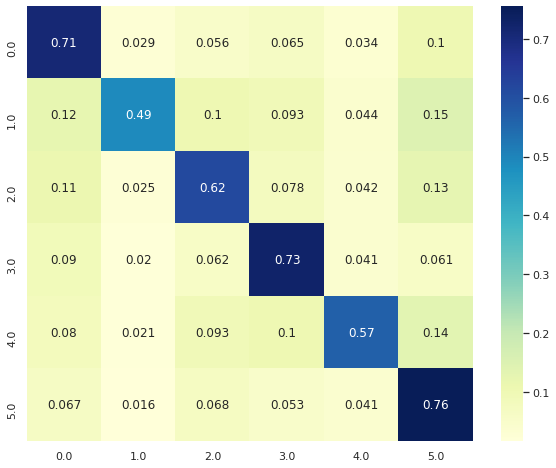

In [61]:
print_stats(y_test, preds_2, clf_test_2.classes_)

In [63]:
preds_ens = np.argmax((preds_proba_2+preds_proba)/2, axis=1)

Accuracy = 0.701
----------------------------------------
Classification report:
               precision    recall  f1-score   support

  REMEMBERING       0.78      0.69      0.73     12966
UNDERSTANDING       0.48      0.54      0.51      1916
     APPLYING       0.47      0.66      0.55      4195
    ANALYZING       0.76      0.71      0.73     10621
   EVALUATING       0.54      0.64      0.59      3483
     CREATING       0.77      0.75      0.76     14269

     accuracy                           0.70     47450
    macro avg       0.63      0.67      0.65     47450
 weighted avg       0.72      0.70      0.71     47450

----------------------------------------
Confusion matrix


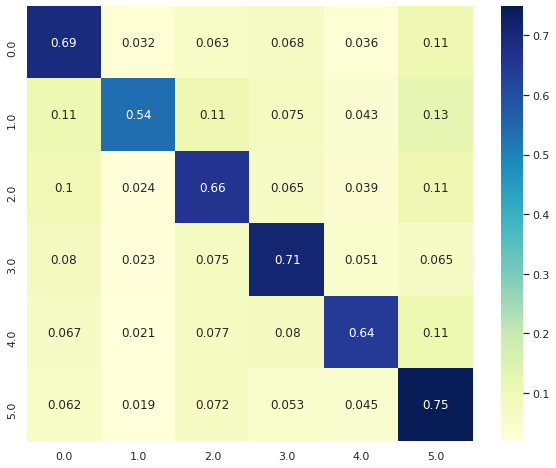

In [64]:
print_stats(y_test, preds_ens, clf_test_2.classes_)

In [66]:
preds_proba_ens = (preds_proba_2+preds_proba)/2

In [67]:
performances = m.get_performance_metrics(df[categories].loc[X_test.index].values, preds_proba_ens, categories)
performances

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
REMEMBERING,7956,33418,2425,3651,0.872,0.245,0.685,0.932,0.766,0.902,0.926,0.724,0.5
UNDERSTANDING,803,44823,489,1335,0.962,0.045,0.376,0.989,0.622,0.971,0.935,0.468,0.5
APPLYING,2212,40817,736,3685,0.907,0.124,0.375,0.982,0.75,0.917,0.89,0.5,0.5
ANALYZING,6761,35634,1980,3075,0.893,0.207,0.687,0.947,0.773,0.921,0.937,0.728,0.5
EVALUATING,1824,42681,622,2323,0.938,0.087,0.44,0.986,0.746,0.948,0.934,0.553,0.5
CREATING,9540,31325,2300,4285,0.861,0.291,0.69,0.932,0.806,0.88,0.927,0.743,0.5


In [68]:
statistics = m.bootstrap_auc(df[categories].loc[X_test.index].values, preds_proba_ens, categories)

In [69]:
m.print_confidence_intervals(categories, statistics)

,Mean AUC (CI 5%-95%)
REMEMBERING,0.93 (0.91-0.94)
UNDERSTANDING,0.93 (0.91-0.96)
APPLYING,0.89 (0.87-0.91)
ANALYZING,0.94 (0.92-0.95)
EVALUATING,0.93 (0.91-0.95)
CREATING,0.93 (0.91-0.94)


### Analise du Score dans une classification à 3 puis à 2 niveau

#### 3 niveaux de classification

- Beginner (Perception): 1 à 2
- Medium (Reproduction): 3 à 4
- Advanced (Perfectionnement): 5 à 6

In [71]:
preds_proba_ens.shape

(47450, 6)

In [77]:
beginner = preds_proba_ens[:, 0]+preds_proba_ens[:, 1]
medium = preds_proba_ens[:,2]+preds_proba_ens[:,3]
advanced = preds_proba_ens[:,4]+preds_proba_ens[:,5]

In [78]:
advanced

array([0.14418657, 0.00446949, 0.21819617, ..., 0.00700605, 0.47928196,
       0.8697933 ], dtype=float32)

In [79]:
preds_ens_3 = np.argmax(np.array([beginner, medium, advanced]).T, axis=1)
preds_ens_3

array([1, 0, 0, ..., 0, 2, 2])

In [80]:
def get_class(nb):
    if nb <2:
        return 0
    elif nb < 4:
        return 1
    else:
        return 2

In [85]:
classes_3 = np.array([get_class(nb) for nb in y_test])
classes_3

array([1, 1, 0, ..., 0, 1, 2])

In [86]:
preds_ens_3.shape, classes_3.shape

((47450,), (47450,))

Accuracy = 0.760
----------------------------------------
Classification report:
              precision    recall  f1-score   support

    Beginner       0.77      0.72      0.75     14610
      Medium       0.73      0.76      0.75     15066
    Advanced       0.78      0.79      0.78     17774

    accuracy                           0.76     47450
   macro avg       0.76      0.76      0.76     47450
weighted avg       0.76      0.76      0.76     47450

----------------------------------------
Confusion matrix


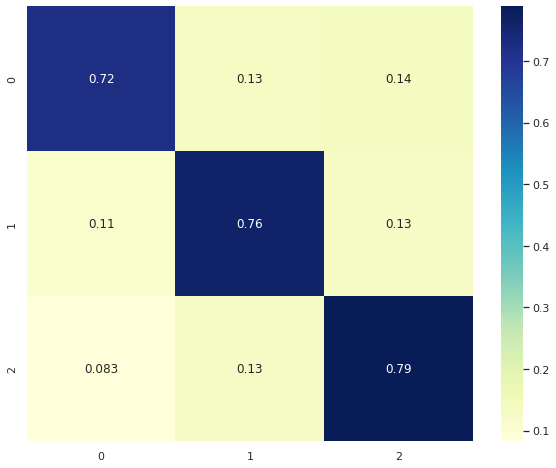

In [87]:
print_stats(classes_3, preds_ens_3, labels=[0, 1, 2], categories=["Beginner", "Medium", "Advanced"])

In [89]:
def get_nd_array(classes):
    res = []
    for classe in np.unique(classes):
        res.append(classes==classe)
    return np.array(res).T

In [90]:
m.get_performance_metrics(get_nd_array(classes_3), np.array([beginner, medium, advanced]).T, ["Beginner", "Medium", "Advanced"])

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Beginner,9884,30578,3127,3861,0.853,0.29,0.719,0.907,0.76,0.888,0.917,0.739,0.5
Medium,10909,28838,2879,4824,0.838,0.332,0.693,0.909,0.791,0.857,0.9,0.739,0.5
Advanced,13311,26492,2986,4661,0.839,0.379,0.741,0.899,0.817,0.85,0.915,0.777,0.5


#### 2 niveaux de classification

- Beginner (Perception): 1 à 2
- Advanced (Perfectionnement): 3 à 6

*Note*: Nous pouvons soit, utiliser la sommes, soit les moyennes

##### Utilisation des sommes

In [93]:
beginner = np.sum(preds_proba_ens[:, :2] ,axis=1)
advanced = np.sum(preds_proba_ens[:, 2:] ,axis=1)

In [94]:
len(beginner)

47450

In [95]:
preds_ens_2 = np.argmax(np.array([beginner, advanced]).T, axis=1)
preds_ens_2

array([1, 0, 1, ..., 0, 1, 1])

In [97]:
classes_2 = np.array([0 if nb<2 else 1 for nb in y_test])
classes_2

array([1, 1, 0, ..., 0, 1, 1])

Accuracy = 0.853
----------------------------------------
Classification report:
              precision    recall  f1-score   support

    Beginner       0.72      0.76      0.74     13011
    Advanced       0.91      0.89      0.90     34439

    accuracy                           0.85     47450
   macro avg       0.81      0.82      0.82     47450
weighted avg       0.86      0.85      0.85     47450

----------------------------------------
Confusion matrix


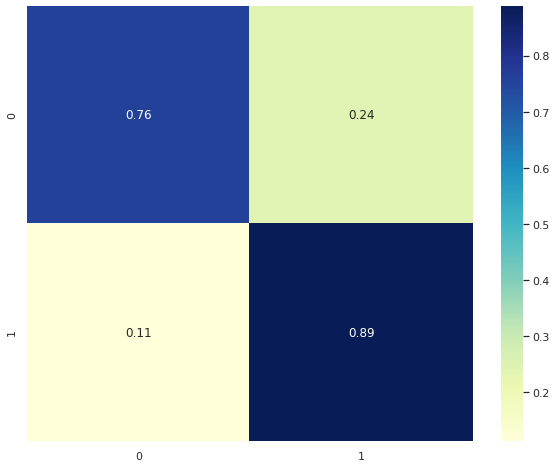

In [98]:
print_stats(classes_2, preds_ens_2, labels=[0, 1], categories=["Beginner", "Advanced"])

In [99]:
m.get_performance_metrics(get_nd_array(classes_2), np.array([beginner, advanced]).T, ["Beginner", "Advanced"])

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
Beginner,9884,30578,3127,3861,0.853,0.29,0.719,0.907,0.76,0.888,0.917,0.739,0.5
Advanced,30578,9884,3861,3127,0.853,0.71,0.907,0.719,0.888,0.76,0.917,0.897,0.5


##### Pondération de chaque somme

In [100]:
preds_ens_2 = np.argmax(np.array([beginner*(2/3), advanced*(1/3)]).T, axis=1)
preds_ens_2

array([1, 0, 0, ..., 0, 0, 1])

Accuracy = 0.833
----------------------------------------
Classification report:
              precision    recall  f1-score   support

    Beginner       0.84      0.67      0.75     17258
    Advanced       0.83      0.93      0.88     30192

    accuracy                           0.83     47450
   macro avg       0.84      0.80      0.81     47450
weighted avg       0.83      0.83      0.83     47450

----------------------------------------
Confusion matrix


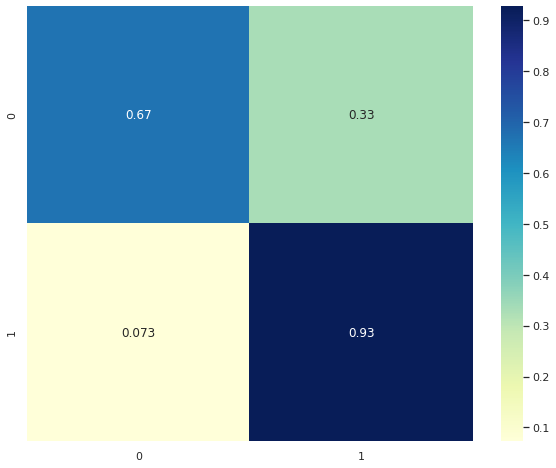

In [101]:
print_stats(classes_2, preds_ens_2, labels=[0, 1], categories=["Beginner", "Advanced"])